In [1]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import spatial_metrics.helper_functions as hf
import spatial_metrics.detect_peaks as dp
import spatial_metrics.spatial_metrics_calcium_binarized_base as pl

%matplotlib widget




'''
If you don't have calcium signal, this part simulates the calcium activity
from a place cell in a 2D enviroment.

You should first set your environment edges. You can think of it as a retangular box in cm.
environment_edges = [[0,30],[0,50]] # in cm [[x_min,x_max],[y_min,y_max]]

Now set the number of place fields (if num_of_fields = 0, then the cell is not a place cell),
their location in the enviroment, and their respective sizes.
'''


In [2]:
# Load your data:

output_dict = np.load('simulated_signal.npy',allow_pickle=True).item()
signal = output_dict['signal']
time_vector = output_dict['time_vector']
x_coordinates = output_dict['x_coordinates']
y_coordinates = output_dict['y_coordinates']
modulated_spike_times_idx = output_dict['spike_times']
environment_edges = output_dict['environment_edges']
sampling_rate = output_dict['sampling_rate']

signal_norm = hf.min_max_norm(signal)


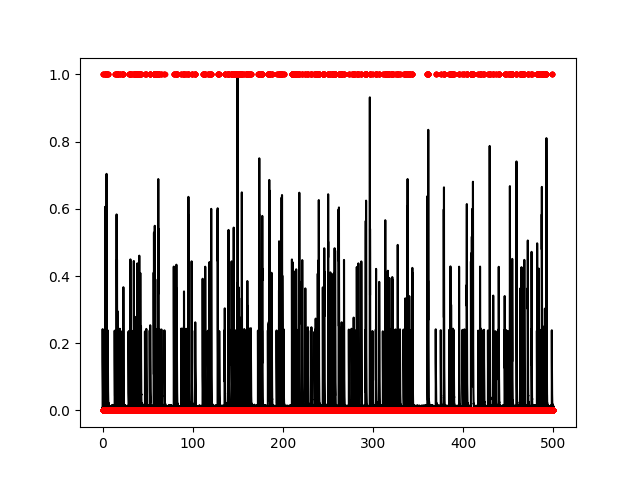

In [3]:
# play with z_threshold just to decide which one is the best for your data

signal_type = 'Binarized'
input_signal = hf.preprocess_signal(signal_norm,sampling_rate,signal_type,z_threshold = 1)

plt.figure()
plt.plot(time_vector,signal_norm,'k')
plt.plot(time_vector,input_signal,'r.')
plt.show()


In [4]:

# Calculate the video sampling rate as the reciprocal of the average time difference between consecutive timestamps.
# This is an approximation for cameras with varying frame rates.
sampling_rate = 1 / np.nanmean(np.diff(time_vector))

# Create a dictionary to hold input parameters for further processing
input_dict = dict()

# Construct the filename and other identifiers for saving the results
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type  # Prefix for the filename
input_dict['animal_id'] = 'NeuronModel'  # Identifier for the animal or model
input_dict['dataset'] = 'Simulation'  # Name of the dataset
input_dict['day'] = 1  # Day or session number
input_dict['neuron'] = 1  # Neuron identifier
input_dict['trial'] = None  # Trial identifier (optional, can be None)
input_dict['saving_path'] = None  # Directory path for saving results (optional, can be None)
input_dict['saving'] = False  # Flag indicating whether to save the results (False means no saving)

# Set parameters related to the signal and environment
input_dict['sampling_rate'] = sampling_rate  # Sampling rate in points per second
input_dict['environment_edges'] = environment_edges  # Coordinates defining the edges of the environment (in cm)

# Set inclusion criteria for the analysis
input_dict['min_time_spent'] = 0  # Minimum time an animal must spend in each xy bin
input_dict['min_visits'] = 0  # Minimum number of visits required in each xy bin
input_dict['min_speed_threshold'] = 0  # Minimum speed threshold in coordinate units

# Set parameters for calculating mutual information
input_dict['x_bin_size'] = 1  # Size of x bins in coordinate units (cm)
input_dict['y_bin_size'] = 1  # Size of y bins in coordinate units (cm)

# Set parameters for surrogate analysis
input_dict['shift_time'] = 200  # Time shift window in seconds for creating surrogate distributions
input_dict['num_cores'] = -1  # Number of CPU cores to use (set to -1 to use all available cores)
input_dict['num_surrogates'] = 80  # Number of surrogate distributions to generate

# Set parameters for plotting place fields
input_dict['smoothing_size'] = 1  # Size of the gaussian smoothing area in bins for plotting place fields

# Set parameters for place fields detection
input_dict['min_num_of_bins'] = 2  # Minimum number of bins required to define a place field

input_dict['field_detection_method'] = 'std_from_field'  # place field detection method (std_from_field or random_fields)

input_dict['percentile_threshold'] = 99  # Percentile threshold for determining place field boundaries when field_detection_method = 'random_fields'
input_dict['detection_threshold'] = 1 # place field detection threshold in std when field_detection_method = 'std_from_field'
input_dict['detection_smoothing_size'] = 1  # Size of the smoothing area in bins for detecting place fields when field_detection_method = 'std_from_field'


place_cell = pl.PlaceCellBinarized(**input_dict)
place_cell_output = place_cell.main(input_signal,time_vector,x_coordinates,y_coordinates)


SpatialMetrics.Binarized.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


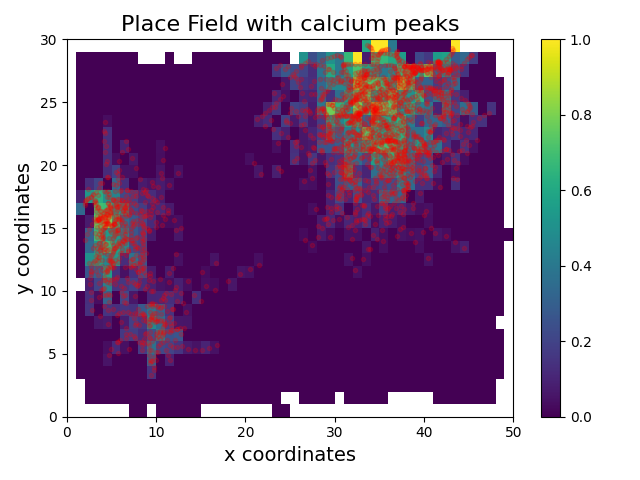

In [15]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field'],shading = 'auto',edgecolors=None)
# plt.pcolormesh(place_cell_output['x_grid'],place_cell_output['y_grid'],place_cell_output['place_field'],edgecolors='red')

plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6,alpha=0.2)
plt.colorbar()
plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



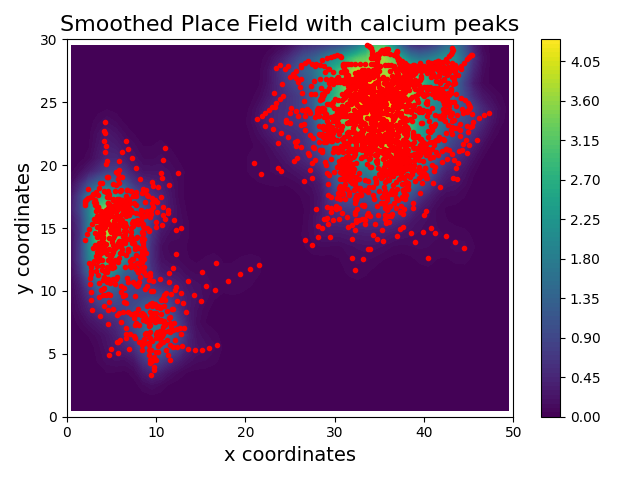

In [16]:


plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100,cmap='viridis')
plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()



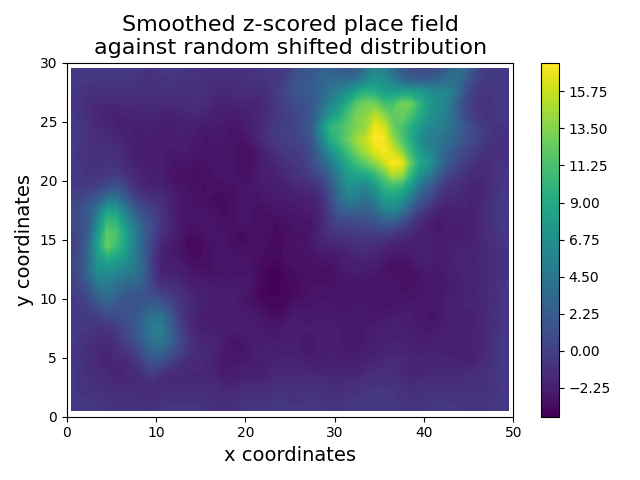

In [17]:

mean_place_field_shifted = np.nanmean(place_cell_output['place_field_smoothed_shifted'],0)
std_place_field_shifted = np.nanstd(place_cell_output['place_field_smoothed_shifted'],0)
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_smoothed_zscored = (place_field_smoothed - mean_place_field_shifted)/std_place_field_shifted

plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_field_smoothed_zscored,100)
plt.colorbar()
plt.title('Smoothed z-scored place field\nagainst random shifted distribution',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


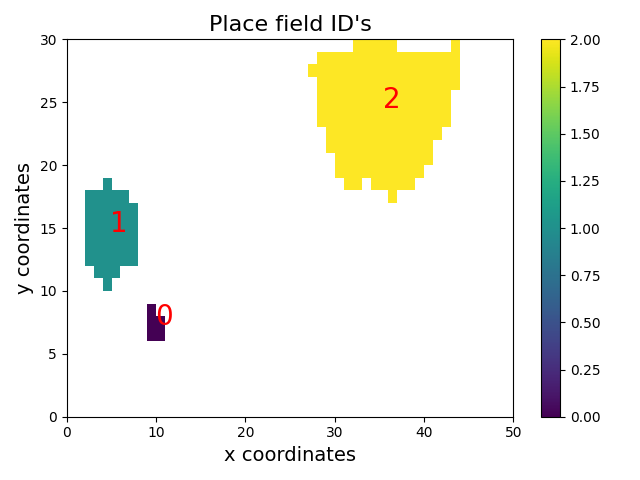

In [18]:

place_cells_x_center_coord = place_cell_output['islands_x_max']
place_cells_y_center_coord = place_cell_output['islands_y_max']

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_identity'])
plt.colorbar()


for counter,(x, y) in enumerate(zip(place_cells_x_center_coord, place_cells_y_center_coord)):
    plt.text(x, y, str(counter), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



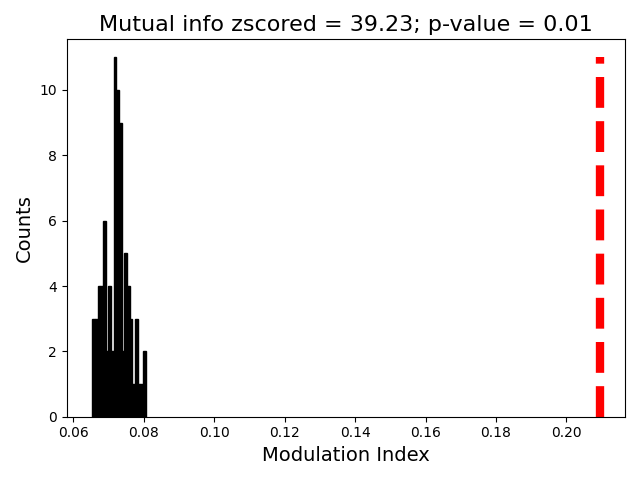

In [19]:

statistic = hf.calculate_p_value(place_cell_output['mutual_info_original'], place_cell_output['mutual_info_shifted'], alternative='two-sided')

counts,bins = np.histogram(place_cell_output['mutual_info_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],statistic.p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


In [20]:
# Place field extension relative to the whole enviroment
place_cell_output['place_cell_extension_absolute']


array([0.00333333, 0.02666667, 0.10266667])

In [21]:
# Place field extension relative to enviroment occupancy
place_cell_output['place_cell_extension_relative']


array([0.00371471, 0.02971768, 0.11441308])

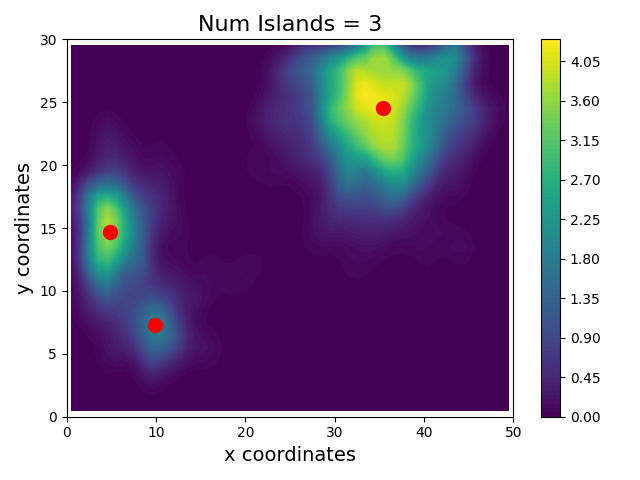

In [22]:
place_cells_x_center_coord = place_cell_output['islands_x_max']
place_cells_y_center_coord = place_cell_output['islands_y_max']

plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100)
# plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.plot(place_cells_x_center_coord,place_cells_y_center_coord,'r.',markersize=20)

plt.title('Num Islands = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


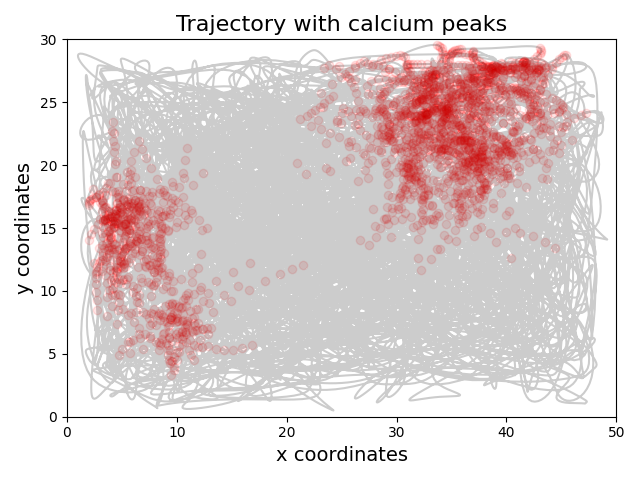

In [23]:

x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=0.1,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


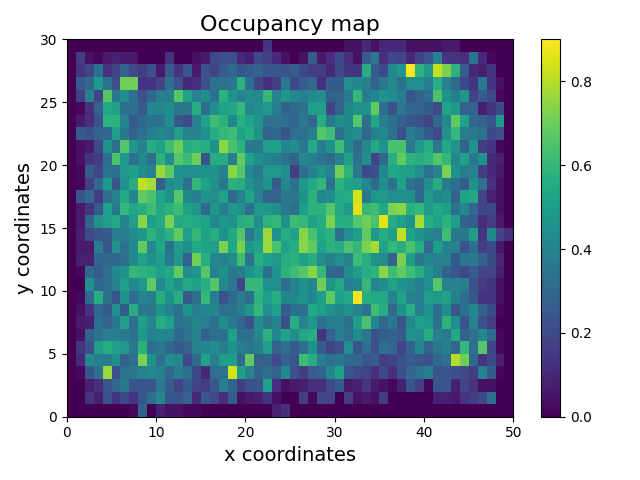

In [26]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['timespent_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


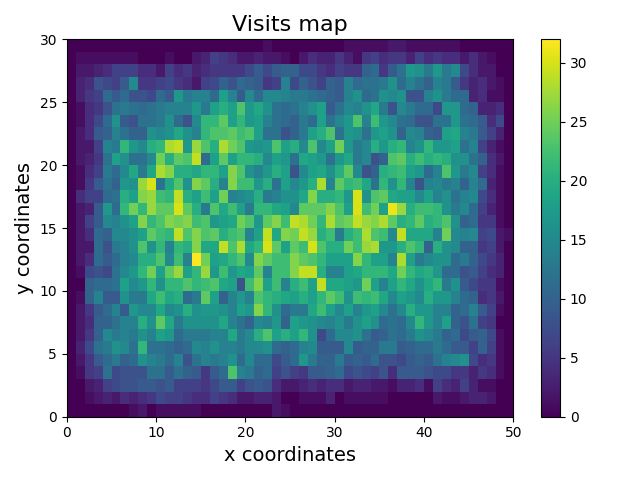

In [28]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


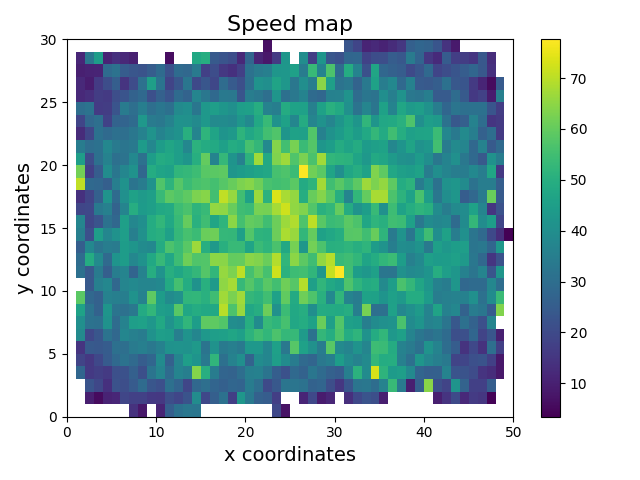

In [27]:


plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['speed_map'])
plt.colorbar()
plt.title('Speed map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()
